In [61]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import os 
import json


In [ ]:
folders=sorted(os.listdir("../input/coin-images/coins/data/train"),key=int)


 ## **Veri setini okuyacak olan Data Generatorler hazırlanılıyor**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=60

# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True)

datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True)

datagen_test = ImageDataGenerator(
    rescale=1./255)

## **Veri seti train,validation ve test olarak okunuyor**

In [ ]:
DATADIR="../input/coin-images/coins/data"

train_generator = datagen_train.flow_from_directory(
        os.path.join(DATADIR,"train"),
        target_size=(200, 200),
        shuffle=True,
        class_mode='categorical')

valid_generator = datagen_valid.flow_from_directory(
       os.path.join(DATADIR,"validation"),
        target_size=(200, 200),
        shuffle=True,
        class_mode='categorical')

test_generator = datagen_test.flow_from_directory(
        os.path.join(DATADIR,"test"),
        target_size=(200, 200),
        shuffle=True,
        class_mode='categorical')

In [ ]:
num_train = len(train_generator.filenames)
num_valid = len(valid_generator.filenames)
num_test = len(train_generator.filenames)

In [ ]:

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.optimizers import Adam



## **En iyi modeli bulmak için birkaç model deneniyor**

In [ ]:
history_list=[] # history of models
base_model = ResNet50(  # using the ResNet50 base model 
    include_top=False,
    weights="imagenet" # imagenet dataset
)
dense_layers=[1,2] # dense layer list that we are going to try
layer_sizes=[512,1024] # layer size list that we are going to try 
for dense_layer in dense_layers: 
    for layer_size in layer_sizes:
        NAME="{}-nodes-{}-dense-{}".format(layer_size,dense_layer,int(time.time())) # uniqe names for all models

        x = base_model.output # we are modeling the output layer of base model
        x = GlobalAveragePooling2D()(x)# add a global spatial average pooling layer
        for l in range (dense_layer):
            x = Dense(layer_size, activation='elu')(x) # adding the dense layer
       
        x = Dropout(0.95)(x) # dropout layer for overfit
        
        predictions = Dense(211, activation='softmax')(x)# add a logistic layer

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)

        for layer in base_model.layers:
            layer.trainable = True

        model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
                     metrics=['accuracy'])
        history = model.fit_generator(train_generator,
                            steps_per_epoch=num_train//batch_size,
                            epochs=40,
                            verbose=1,
                            validation_data=valid_generator,
                            validation_steps=num_valid//batch_size)
        history_list.append([NAME,history]) # adding models to histroy list when the training is over

## **Oluşturulan modeller garfikler ile görselleştiriliyor**

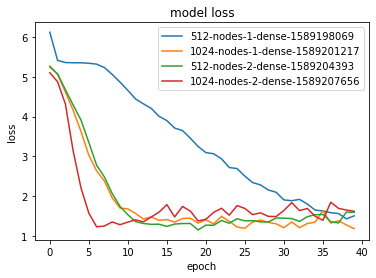

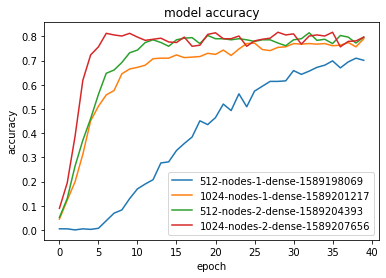

In [100]:
def plot_history(history_list):
    
    for history in history_list:
        plt.plot(history[1].history['val_loss'],label=history[0])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.show()  
   
    for history in history_list:
        plt.plot(history[1].history['val_accuracy'],label=history[0])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.show()   
    
plot_history(history_list)   

## **En uygun model seçiliyor ve oluşturuluyor**

In [63]:

base_model = ResNet50(
    include_top=False,
    weights="imagenet"
)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='elu')(x)
x = Dropout(0.95)(x)
# and a logistic layer
predictions = Dense(211, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True
    
from tensorflow.keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

num_train = len(train_generator.filenames)
num_valid = len(valid_generator.filenames)
num_test = len(train_generator.filenames)


history = model.fit_generator(train_generator,
                    steps_per_epoch=num_train//batch_size,
                    epochs=40,
                    verbose=1,
                    callbacks=my_callbacks,
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)

Train for 106 steps, validate for 14 steps
Epoch 1/40
106/106 [==============================] - 83s 787ms/step - loss: 7.0966 - accuracy: 0.0065 - val_loss: 6.1487 - val_accuracy: 0.0067
Epoch 2/40
106/106 [==============================] - 76s 712ms/step - loss: 5.6387 - accuracy: 0.0047 - val_loss: 17.1252 - val_accuracy: 0.0134
Epoch 3/40
106/106 [==============================] - 76s 719ms/step - loss: 5.5198 - accuracy: 0.0071 - val_loss: 5.3669 - val_accuracy: 0.0067
Epoch 4/40
106/106 [==============================] - 76s 721ms/step - loss: 5.4079 - accuracy: 0.0144 - val_loss: 5.7128 - val_accuracy: 0.0045
Epoch 5/40
106/106 [==============================] - 77s 726ms/step - loss: 5.3479 - accuracy: 0.0171 - val_loss: 5.3469 - val_accuracy: 0.0045
Epoch 6/40
106/106 [==============================] - 77s 731ms/step - loss: 5.2647 - accuracy: 0.0245 - val_loss: 5.3189 - val_accuracy: 0.0312
Epoch 7/40
106/106 [==============================] - 78s 734ms/step - loss: 5.1696 - 

## **Test verileri test ediliyor**

In [97]:
score = model.evaluate_generator(test_generator, verbose=1)
print('\n', 'Test accuracy:', score[1])

27/27 [==============================] - 9s 316ms/step - loss: 0.6674 - accuracy: 0.8472

 Test accuracy: 0.8471564


In [68]:
with open('../input/coin-images/coins/data/cat_to_name.json') as f:
    classes = json.load(f)


## **Random test verileri tahmin edilip karşılaştırılıyor**

In [1]:
from keras.preprocessing.image import  image
int_to_dir = {v: k for k, v in train_generator.class_indices.items()}

def get_prediction(img, real_label):
    img = image.img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)

    prediction = model.predict(img_expand)
    prediction_int = np.argmax(prediction)

    dir_int = int_to_dir[prediction_int]
    label_name = classes[str(dir_int)]
    
    print("Predicted: {}\nReal:      {}".format(label_name, classes[str(real_label)]))
    print()


for i in range(10):
    random_index = np.random.randint(0, len(test_generator.filenames))
    
    img = test_generator.filenames[random_index]
    img = image.load_img("../input/coin-images/coins/data/test/"+img, target_size=(200,200))
    real_label = test_generator.filenames[random_index].split("/")[0]

    get_prediction(img, real_label)

ModuleNotFoundError: No module named 'keras'